# Response time minimization - Troms police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

#### Troms police district
The police district comprises 18 municipalities in Troms and Finnmark counties. The district is organized into five police station districts/geographic operating units, with a total of ten police stations, as well as five functional operating units and three management support staffs. The head office is located in Tromsø.


In [5]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-13T12:51:09.074067+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp
import highspy
import folium
import utilityModule # own custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

folium    : 0.16.0
pandas    : 2.2.1
highspy   : 1.5.3
shapely   : 2.0.3
matplotlib: 3.8.3
pyproj    : 3.6.1
numpy     : 1.26.4
pandana   : 0.7
osmnx     : 1.9.1
pulp      : 2.8.0
networkx  : 3.2.1
geopandas : 0.14.3



## 0. Load road network

We load a road network of Oslo police district that has been preprocessed.
- Network type: drive
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633
- Network already contains edge weights (travel time in seconds)
- Node centrality measures has already been calculated for the network and stored as a CSV file.

In [7]:
### Load road network file of Øst police district, Norway
# Read from local path
Troms_filepath = "../data/Troms/TromsDriveImputed.graphml" # with travel time attribute
Troms_graph = ox.load_graphml(Troms_filepath) # originally in WGS84 (EPSG:4326)

Type of Troms_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of Troms_graph:  EPSG:32633


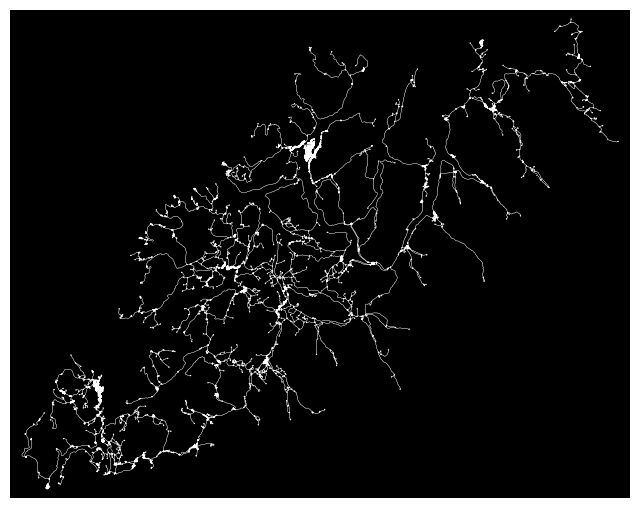

In [8]:
Troms_graph = ox.projection.project_graph(Troms_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of Troms_graph: {type(Troms_graph)}")
print(f"CRS of Troms_graph:  {Troms_graph.graph['crs']}")

# plot graph
fig, ax = ox.plot_graph(Troms_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [9]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(Troms_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid  \
u          v          key                                                      
5795532316 5795556879 0    [423928962, 66180591, 318402773, 612236920, 61...   
           5795532316 0                                            423928968   

                                highway  oneway reversed   length  \
u          v          key                                           
5795532316 5795556879 0    unclassified   False     True 6955.885   
           5795532316 0    unclassified   False    False  194.564   

                                    name  \
u          v          key                  
5795532316 5795556879 0    Dividalsveien   
           5795532316 0              NaN   

                                                                    geometry  \
u          v          key                                                      
5795532316 5795556879 0    LINESTRING (692311.830 7631157.736, 692299.021...   
           5795532316 0    LINESTRING (692311.830 7631157.736, 692312.361...   

                           speed_kph  travel_time  ref maxspeed bridge width  \
u          v          key                                                      
5795532316 5795556879 0       41.900      597.600  NaN      NaN    NaN   NaN   
           5795532316 0       41.900       16.700  NaN      NaN    NaN   NaN   

                          tunnel access lanes junction  
u          v          key                               
5795532316 5795556879 0      NaN    NaN   NaN      NaN  
           5795532316 0      NaN    NaN   NaN      NaN

In [10]:
nodes.head(2) # verify nodes contain x and y coordinates

y          x  street_count    lon    lat highway  \
osmid                                                                   
5795532316 7631157.736 692311.830             3 19.753 68.725     NaN   
5795556879 7637342.199 689844.701             3 19.704 68.782     NaN   

                                  geometry  
osmid                                       
5795532316  POINT (692311.830 7631157.736)  
5795556879  POINT (689844.701 7637342.199)

In [11]:
# print number of nodes and edges
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")

Number of nodes: 8673
Number of edges: 19814


## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based purely on population count. Should fall in range [2000,2500]  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB - Oslo police district.
- Correct extent: Combined municipalities of  Asker, Bærum and Oslo.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [12]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
Troms_polygon_path = "../data/Troms/TromsCombinedPolygon.geojson"
Troms_polygon_gdf = gpd.read_file(Troms_polygon_path)
Troms_polygon_gdf = Troms_polygon_gdf.to_crs(Troms_graph.graph['crs']) # convert to same CRS as the road network

In [13]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/Troms/TromsPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(Troms_graph.graph['crs']) # convert to same CRS as the road network

In [14]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  25540007590250           8   
1  25557507590500           1   

                                            geometry  
0  POLYGON ((554000.000 7590250.000, 554000.000 7...  
1  POLYGON ((555750.000 7590500.000, 555750.000 7...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range of [2000,2500].

In [15]:
# calculate the number of points to simulate in each grid cell - vectorized version
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=2000, max_range=2500)

# print the number of cells with 0, 1, 2, ..., 9 events
for i in range(0, 7):
    print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Convergence reached with multiplier: 0.009999450683593751 (total points: 1103)
Nr of cells with 0 events: 9401
Nr of cells with 1 events: 493
Nr of cells with 2 events: 164
Nr of cells with 3 events: 57
Nr of cells with 4 events: 16
Nr of cells with 5 events: 3
Nr of cells with 6 events: 4


id  population  \
7817  26535007732250         772   
7501  26525007730000         626   
7696  26557507733750         585   

                                               geometry  num_points  
7817  POLYGON ((653500.000 7732250.000, 653500.000 7...           8  
7501  POLYGON ((652500.000 7730000.000, 652500.000 7...           6  
7696  POLYGON ((655750.000 7733750.000, 655750.000 7...           6

In [16]:
%%time
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

CPU times: total: 328 ms
Wall time: 523 ms


geometry
0  POINT (566933.236 7603774.883)
1  POINT (561211.380 7608020.278)
2  POINT (563834.494 7608502.762)

In [17]:
# print number of nodes
print(f"Number of nodes: {len(nodes)}")

Number of nodes: 8673


In [28]:
# print(f"Number of nodes: {len(nodes)}")
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, density_threshold=1.2e-11, simplification_tolerance=5.0, plot_results=False)

Density: Min: 7.318e-187 | Median: 4.166e-13 | Mean: 2.370e-11 | Max: 1.072e-09


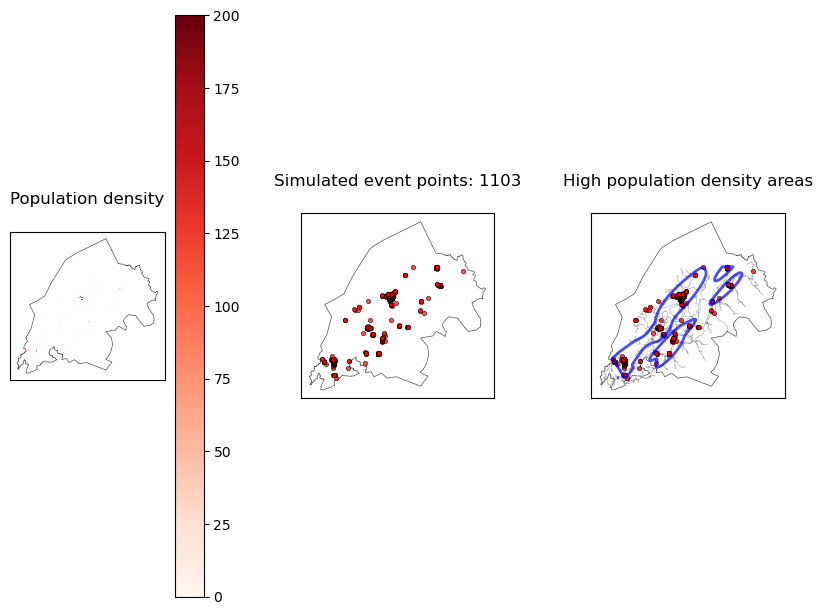

In [29]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(Troms_polygon_gdf, population_gdf, event_points_gdf, high_pop_density_area, edges)

*(Skip using this kernel density function to constrain the sampling of car nodes)*

Function show stability issues for several districts.

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measure as node attribute  
2.2 Sample candidate points and filter out poor candidate points

In [30]:
nodes.head(2)

y          x  street_count    lon    lat highway  \
osmid                                                                   
5795532316 7631157.736 692311.830             3 19.753 68.725     NaN   
5795556879 7637342.199 689844.701             3 19.704 68.782     NaN   

                                  geometry  
osmid                                       
5795532316  POINT (692311.830 7631157.736)  
5795556879  POINT (689844.701 7637342.199)

### 2.1 Add Centrality measure as node attribute

Next we load the pre-computed closeness centrality and add it as an attribute to the nodes GeoDataFrame.  

*Closeness centrality is a measure of how close a node is to all other nodes in the network.   
It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph.*

In [31]:
# import node closeness centrality from file
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

nodes_centrality_import = pd.read_csv("../data/Troms/TromsNodeCentrality.csv")

In [32]:
# Now use the merge function. Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')
print(f"Number of nodes: {len(nodes)}")
nodes.head(2)


Number of nodes: 8673


y          x  street_count    lon    lat highway  \
0  7631157.736 692311.830             3 19.753 68.725     NaN   
47 7637342.199 689844.701             3 19.704 68.782     NaN   

                          geometry       osmid  closeness_centrality  \
0   POINT (692311.830 7631157.736)  5795532316                 0.000   
47  POINT (689844.701 7637342.199)  5795556879                 0.000   

    betweenness_centrality  
0                    0.000  
47               34658.000

In [33]:
# After the merge, if you want 'osmid' as a column instead of an index, you can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count    lon    lat highway  \
osmid                                                                   
5795532316 7631157.736 692311.830             3 19.753 68.725     NaN   
5795556879 7637342.199 689844.701             3 19.704 68.782     NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
5795532316  POINT (692311.830 7631157.736)                 0.000   
5795556879  POINT (689844.701 7637342.199)                 0.000   

            betweenness_centrality  
osmid                               
5795532316                   0.000  
5795556879               34658.000

Now, that the closeness centrality is added as an attribute to the ``nodes`` GeoDataFrame, we can use this to filter out better candidate locations for the police cars.

In [34]:
# # inspect stats for columns closeness_centrality and betweenness_centrality
# print(f"Stats for closeness_centrality:\n{nodes['closeness_centrality'].describe()}")
# print(f"Stats for betweenness_centrality:\n{nodes['betweenness_centrality'].describe()}")


### 2.2 Sample candidate points and filter out poor candidate points

#### Steps:
1. Sample a set of random points from the road network (using the high population density areas as a polygon).
2. Filter out points that are too close to the border of the road network (closeness centrality threshold).
3. Filter out points that are too close to each other.
4. Filter out points that are too close to the existing police stations.

In [35]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 200

# sample X random source nodes from the area high_pop_density_area
# car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = nodes.copy()
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED, replace=False)
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 8673, nr of police car nodes: 200


y          x  street_count    lon    lat highway  \
osmid                                                                   
5743949008 7736179.458 654821.223             1 18.999 69.688     NaN   
5779117615 7624973.105 556743.210             1 16.402 68.731     NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
5743949008  POINT (654821.223 7736179.458)                 0.000   
5779117615  POINT (556743.210 7624973.105)                 0.000   

            betweenness_centrality  
osmid                               
5743949008                   0.000  
5779117615                   0.000

Input nr of car nodes: 200
Remaining nr of car nodes: 160, after discarding the 40 (20%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


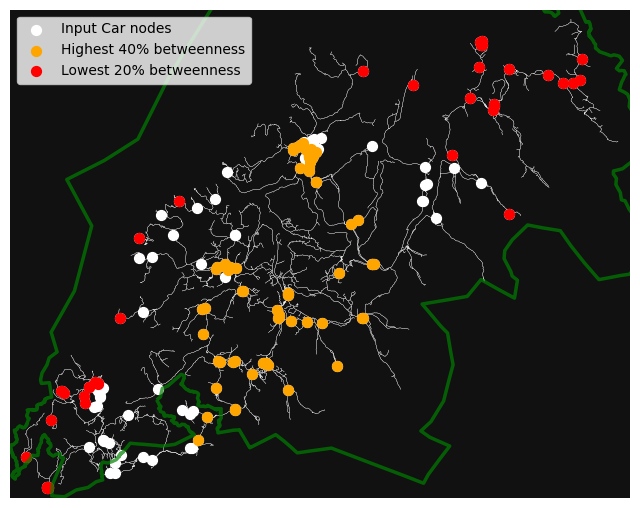

In [39]:
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=Troms_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.20, input_graph=Troms_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 160
Remaining nr of car nodes: 88, after discarding the 72 (45%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


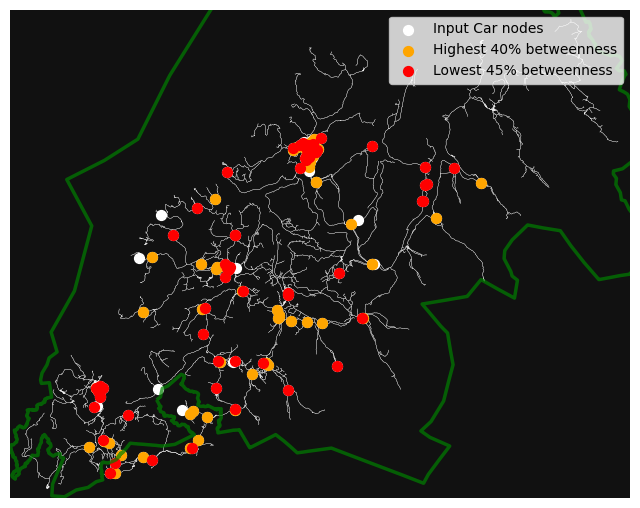

In [40]:
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=Troms_polygon_gdf, top_percent=0.4, bottom_percent=0.45, 
                                                            input_graph=Troms_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 88
Remaining nr of car nodes: 20, after removing the 68 nodes that are within 15000 m of each other



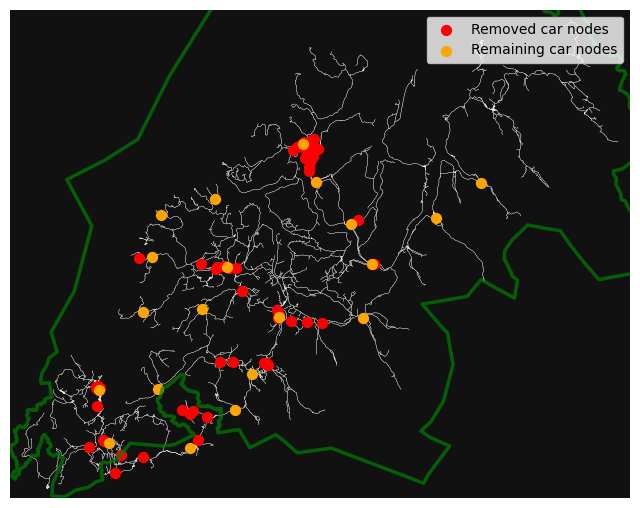

In [43]:
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=Troms_polygon_gdf, 
                        min_distance=15000, input_graph=Troms_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

Now we use the GeoDataFrames from `osmnx` to create a `pandana` network.

Pandana networks is defined like this:   
`pandana.network.Network(node_x, node_y, edge_from, edge_to, edge_weights, twoway=True)`  

 **edge_weights**: DataFrame, all numerics   
- Specifies one or more impedances on the network which define the distances between nodes.  
- Multiple impedances can be used to capture travel times at different times of day, for instance.

We will use both ``length`` and ``travel_time`` as edge weights. However, we must specify which one to use when querying the network (cannot calculate with both at the same time).

In [44]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()
# nodes = nodes.reset_index()

# create network with pandana
Troms_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of Troms_network_pdna: {type(Troms_network_pdna)}")
print(f"Network nodes:")
Troms_network_pdna.nodes_df.head(2)

type of Troms_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                            
5795532316 692311.830 7631157.736
5795556879 689844.701 7637342.199

In [45]:
print(f"Network edges: ")
Troms_network_pdna.edges_df.head(2)

Network edges: 


from          to   length  travel_time
0  5795532316  5795556879 6955.885      597.600
1  5795532316  5795532316  194.564       16.700

In [46]:
# %%time
# Troms_network_pdna.precompute(3000)

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network. Therefore, we need to snap the event points to the Pandana network.

In [47]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = Troms_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry   nearest_node          x           y
0  POINT (566933.236 7603774.883) 5787003003.000 566660.801 7603924.302
1  POINT (561211.380 7608020.278) 5779135607.000 561185.399 7608007.004

In [48]:
# Get list of nearest node ids for event locations
event_nodes_pdna = Troms_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = Troms_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([5795597454,   33989401, 5768571482, 4159438523,    9056775],
      dtype=int64)

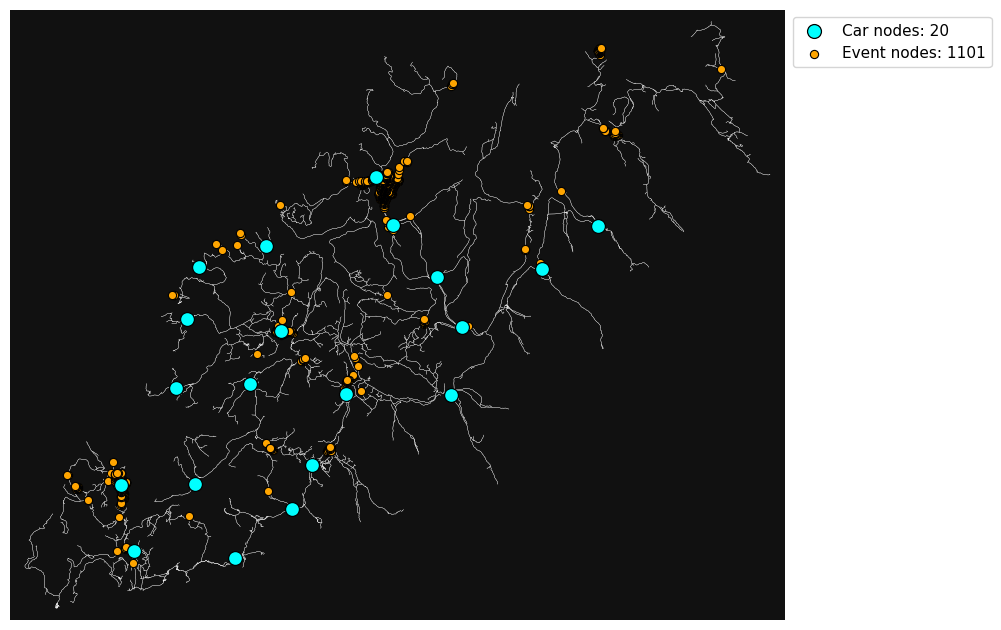

In [49]:
# Plot overview of Car nodes and Event nodes
fig, ax = ox.plot_graph(Troms_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

First, identify the nearest node to each Police car and Event.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [50]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [51]:
%%time
# distance between each possible pair of facilities-clients combination
distances = Troms_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = Troms_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(travel_times))
print("Number of travel_times calculated: ", len(travel_times))
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5])

<class 'list'>
Number of travel_times calculated:  22020
5 first origin-destination distances [m]     : [127230.651, 147626.337, 134695.187, 134562.27, 135157.279]
5 first origin-destination travel times [sec]: [6082.499, 7087.499, 6518.599, 6508.899, 6575.599]
CPU times: total: 344 ms
Wall time: 91.5 ms


In [52]:
# print the statistics for distances and travel times
# print("Distances statistics:")
# print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())


Travel times statistics:
count   22020.000
mean     8175.646
std      4022.624
min         0.000
25%      5515.075
50%      8549.250
75%     10856.349
max     21977.999
dtype: float64


In [53]:
# Restructure the distances and travel times arrays into a DataFrame (CTroms Matrix) and add the car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix.head(2)

distance  travel_time   carNodeID  eventNodeID
0 127230.651     6082.499  5795597454   5787003003
1 147626.337     7087.499  5795597454   5779135607

In [54]:
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time   carNodeID  eventNodeID          x           y
0 127230.651     6082.499  5795597454   5787003003 566660.801 7603924.302
1 147626.337     7087.499  5795597454   5779135607 561185.399 7608007.004

In [55]:
# Save cTroms matrix to CSV
CostMatrix.to_csv("../data/Troms/TromsCostMatrix.csv", index=False)

# # import cTroms matrix from CSV
# CostMatrix_imported = pd.read_csv("../data/Troms/TromsCostMatrix.csv")
# CostMatrix_imported.head(2)

CostMatrix.drop(columns="distance", inplace=True)

Now, we have made Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

### Notation

Let's define the notation that will be used to formulate the problem:
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events, each associated with a node in $N$ and a severity score.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.

### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M_i \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data structures for efficient computation

In [56]:
%%time
# find the total number of unique events from the reduced cTroms matrix
nr_of_unique_events = CostMatrix['eventNodeID'].nunique()
print(f"Total number of unique events: {nr_of_unique_events}")

# Preprocess the cTroms matrix
# 1) Convert to a dictionary for fast lookup
# 2) Reduce problem size: Remove top x% travel times, as there is probably a closer car to the event
DISCARD_THRESHOLD = 0.40
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Total number of unique events: 961
Filtering out 40% highest travel times - keeping only travel times <= 9821 sec, or 163.7 min
Original nr of pairs: 19220 | Filtered nr of pairs: 11532
Original max travel time: 21977.999 | Filtered max travel time: 9821.3
Original min travel time: 0.0 | Filtered min travel time: 0.0
CPU times: total: 0 ns
Wall time: 28.6 ms


### 5.2 Setup LP problem

In [57]:
# Constants
NR_OF_CARS = 4
CAR_CAPACITY = 380

# # Sets
P = CostMatrix['carNodeID'].unique()  # Potential police car locations
E = CostMatrix['eventNodeID'].unique()  # Events

# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 20
Number of events: 961
Number of decision variables: 11552
Number of constraints: 12514
Number of non-zero coefficients: 11552
Number of non-zero coefficients in the objective function: 11531
PuLP Problem setup took 0.58 seconds


### 5.5 Run the solvers

- **PULP_CBC (COIN-OR Branch and Cut)** - open-source solver that is included in the PuLP package.
- **HiGHS (High-Performance Solver)** - a high-performance solver that use the HiGHS optimization engine.

1st run of each solver will relax the integer variable constraint (`mip=False`) for fast computation. 2nd run of each solver will use proper integer constraints (`mip=True`) to get the slow, final solution for verification.

*Recall this is a minimization problem, so the lower the objective value, the better the solution.*

In [58]:
# Inspect available pulp solvers
pulp.listSolvers(onlyAvailable=True)

['GLPK_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'HiGHS']

PULP_CBC_CMD with LP relaxation found 3/4 locations in 1.54 seconds.
Switching to MILP solver configuration to find optimal solution.



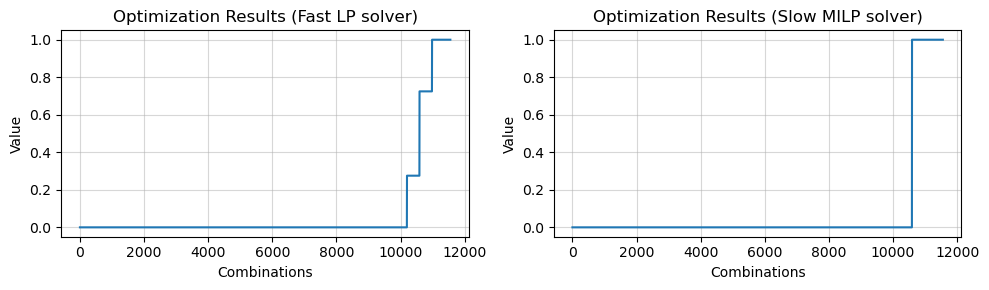

Optimal police car locations found: 4/4 in 14.33 seconds: [2425235123 5765807173 5759130552 1189923275]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 1586694.2610 seconds, or 26444.90 minutes, or 440.75 hours
(Note: Currently reducing the Cost matrix by 40%)
CPU times: total: 1.34 s
Wall time: 17 s


In [59]:
%%time
# Run the solver
solve = utilityModule.run_solvers(problem, P, nr_of_locations=4, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=True)
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")

### 5.6 Extract results for inspection

In [60]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)

Optimal police car locations: dict_keys([2425235123, 5765807173, 5759130552, 1189923275])
Car 2425235123 is assigned 321/380 events
Car 5765807173 is assigned 43/380 events
Car 5759130552 is assigned 380/380 events
Car 1189923275 is assigned 217/380 events
Summing the events for each car gives 961 events, which should equal the total number of unique events: 961


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 20 | Optimal locations in solution: 4
- Events: 961 | Max event capacity per police car: 380

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 1586694 sec | 26444.9 min | 440.75 hours

Police car id: 2425235123 handles 321 events | Capacity: 84.47% | Total response time: 18905.92 min | Avg response time: 58.90 min
Police car id: 5765807173 handles 43 events | Capacity: 11.32% | Total response time: 2800.54 min | Avg response time: 65.13 min
Police car id: 5759130552 handles 380 events | Capacity: 100.00% | Total response time: 3154.92 min | Avg response time: 8.30 min
Police car id: 1189923275 handles 217 events | Capacity: 57.11% | Total response time: 1583.52 min | Avg response time: 7.30 min


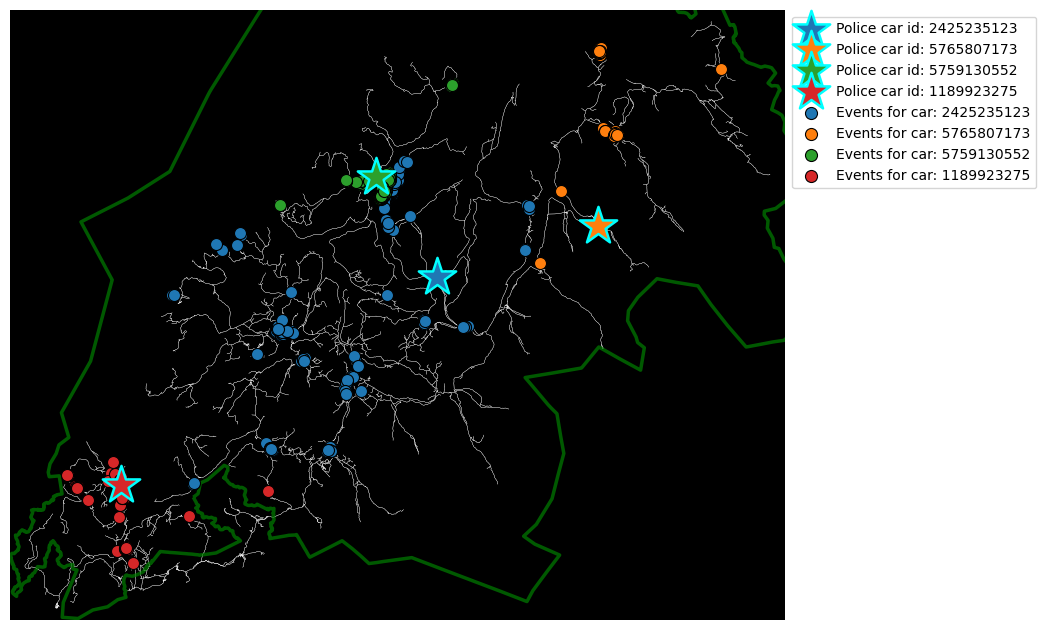

CPU times: total: 1.41 s
Wall time: 1.92 s


In [61]:
%%time
utilityModule.plot_optimal_allocations(Troms_graph, Troms_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                        car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem)

## 6.2 Visualize Isochrones - How far can you drive in different time intervals?
How far can you drive in 1.5, 4 and 8 minutes from the origin nodes? We'll use NetworkX to induce a subgraph of gruner_graph within each distance, based on travel time.  
We also, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [62]:
# Define how many trip times to visualize
TRIP_TIMES = [20, 60, 120]  # in minutes
ISO_COLORS = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges

Isochrone polygons for the travel times: [20, 60, 120] minutes


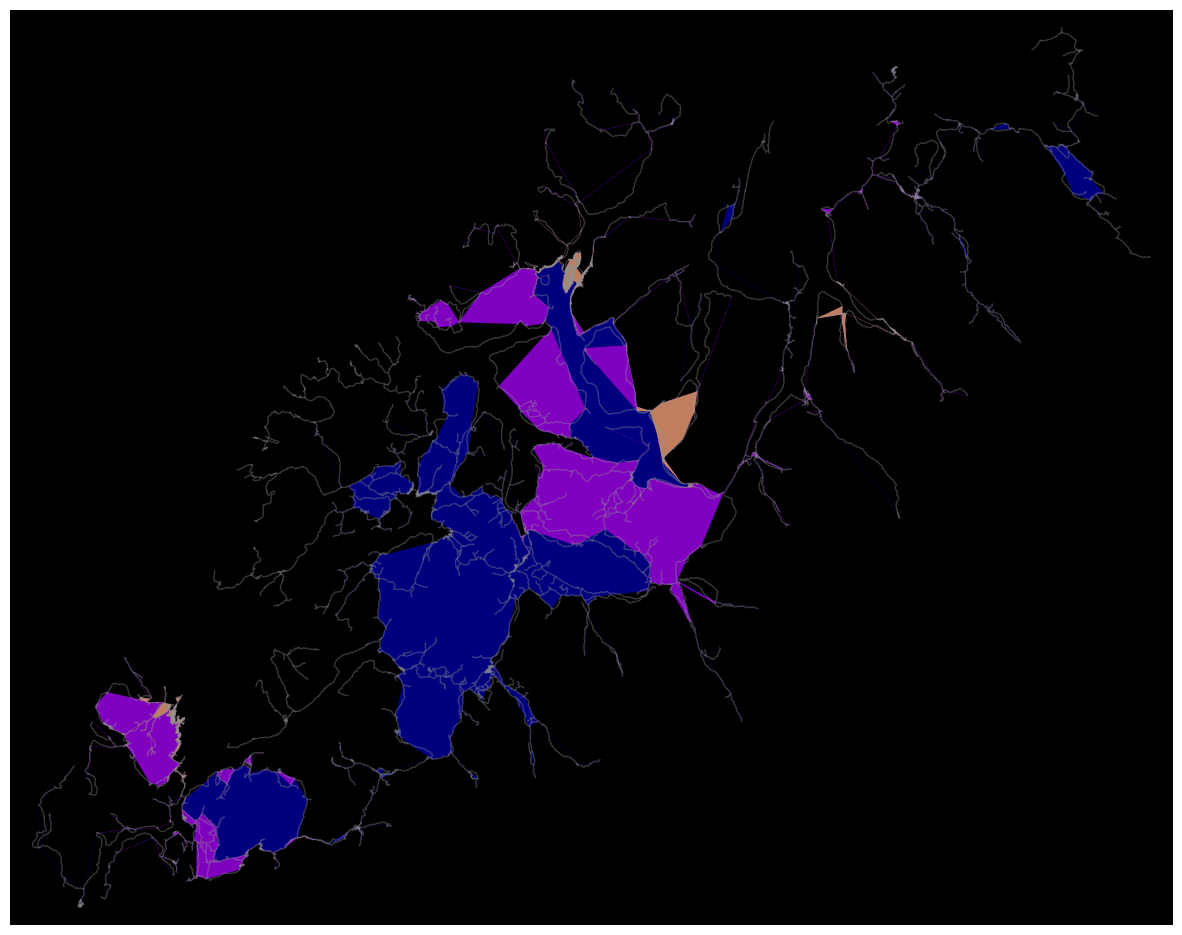

CPU times: total: 27.6 s
Wall time: 35.2 s


In [63]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(Troms_graph, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=30, node_buff=0, infill=True)

# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(Troms_graph, isochrone_polys)

# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(Troms_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
# iso_colors = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges
for merged_poly, color in zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS):
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=0.5, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=0.5, zorder=-1)
        ax.add_patch(patch)

print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

In [64]:
%%time
# Plot leaflet map
graph_map = utilityModule.plot_leaflet_map(Troms_graph, TRIP_TIMES, merged_isochrones, Troms_polygon_gdf, background_poly=True)
graph_map

CPU times: total: 250 ms
Wall time: 511 ms
